In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data.csv', index_col=0, parse_dates=['date']) 
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [3]:
len(df)

21597

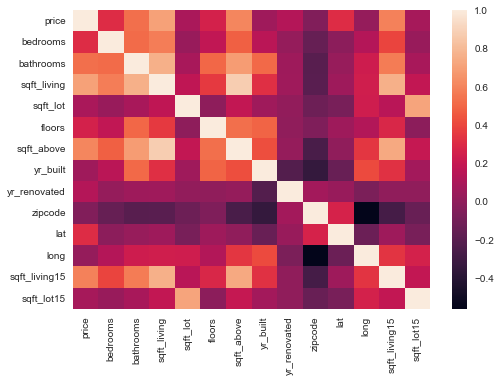

In [4]:
sns.heatmap(df.corr());

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [5]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [6]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [7]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Bedrooms

In [69]:
bedrooms_count = print(df['bedrooms'].value_counts())

3     8610
4     5480
2     2547
5     1167
6      197
1      171
7       24
8        9
9        4
10       2
11       1
Name: bedrooms, dtype: int64


In [8]:
#drop the 33 bedroom outlier 
df = df[df['bedrooms'] != 33]

In [9]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins=[0,1,2,3,4,5,6,99], labels=['1_bed','2_bed','3_bed','4_bed','5_bed','6_bed','7+_bed'])

### Price

In [10]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q25, price_q75 = np.percentile(df['price'], [25, 75])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -162500.0 
price_max: 1129500.0


In [11]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [12]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -2975.125 
sqft_lot_max: 18291.875


In [13]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Grade

In [14]:
grade_count = print(df['grade'].value_counts())

7 Average        8371
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64


In [15]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

# Train-Test Split

In [16]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Categorical Variables

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18212 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           18212 non-null  datetime64[ns]
 1   price          18212 non-null  float64       
 2   bedrooms       18212 non-null  int64         
 3   bathrooms      18212 non-null  float64       
 4   sqft_living    18212 non-null  int64         
 5   sqft_lot       18212 non-null  int64         
 6   floors         18212 non-null  float64       
 7   waterfront     16163 non-null  object        
 8   view           18158 non-null  object        
 9   condition      18212 non-null  object        
 10  grade          18212 non-null  object        
 11  sqft_above     18212 non-null  int64         
 12  sqft_basement  18212 non-null  object        
 13  yr_built       18212 non-null  int64         
 14  yr_renovated   14966 non-null  float64       
 15  zipco

In [18]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2049
view               54
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3246
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
bedrooms_bin        0
dtype: int64

In [19]:
#drop the 33 bedroom outlier 
df.drop(['date', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_bin
id,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,1955,98178,47.5112,-122.257,1340,5650,3_bed
6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,1951,98125,47.7210,-122.319,1690,7639,3_bed
5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,1933,98028,47.7379,-122.233,2720,8062,2_bed
2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,1965,98136,47.5208,-122.393,1360,5000,4_bed
1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,1987,98074,47.6168,-122.045,1800,7503,3_bed


### Bedroom Bins

In [20]:
X_train, X_test, encoded_bedrooms_bins = ohe(X_train, X_test, ['bedrooms_bin'])

In [21]:
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,bedrooms_bin,bedrooms_bin_x0_2_bed,bedrooms_bin_x0_3_bed,bedrooms_bin_x0_4_bed,bedrooms_bin_x0_5_bed,bedrooms_bin_x0_6_bed,bedrooms_bin_x0_7+_bed
id,,,,,,,,,,,,,,,,,,,,,
3649100320,2015-04-30,2,1.00,1220,10000,1.0,NO,NONE,Very Good,7 Average,...,-122.241,2000,9600,2_bed,1.0,0.0,0.0,0.0,0.0,0.0
7823700005,2014-07-07,3,1.75,1940,7500,1.5,NO,NONE,Good,8 Good,...,-121.993,1650,7500,3_bed,0.0,1.0,0.0,0.0,0.0,0.0
2024059130,2015-01-09,4,3.75,3280,6000,2.0,NO,NONE,Average,9 Better,...,-122.190,2900,10108,4_bed,0.0,0.0,1.0,0.0,0.0,0.0
1133000235,2014-06-16,6,2.25,3550,11780,1.0,NO,NONE,Good,8 Good,...,-122.312,2360,8850,6_bed,0.0,0.0,0.0,0.0,1.0,0.0
1604602050,2014-07-11,3,2.50,1610,2527,2.0,NaN,AVERAGE,Average,9 Better,...,-122.290,1610,4173,3_bed,0.0,1.0,0.0,0.0,0.0,0.0


### Condition

In [22]:
condition_count = df['condition'].value_counts()
condition_count

Average      11900
Good          4726
Very Good     1433
Fair           132
Poor            21
Name: condition, dtype: int64

In [23]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [24]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [25]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Grade

In [26]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### View

In [27]:
X_train['view'].isna().sum()

45

In [28]:
view_count = df['view'].value_counts()
view_count

NONE         16870
AVERAGE        681
GOOD           257
FAIR           246
EXCELLENT      104
Name: view, dtype: int64

In [29]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [30]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [31]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [32]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [33]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [34]:
waterfront_train = X_train[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]

waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_train

In [35]:
waterfront_test = X_test[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]

waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_test

### Zipcode

In [36]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [37]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -0.0002287894919794642


In [38]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.598983
sqft_living15    0.536502
sqft_above       0.492556
lat              0.450100
bathrooms        0.429260
bedrooms         0.292722
floors           0.262999
long             0.034681
sqft_lot15       0.024641
yr_built         0.024433
sqft_lot         0.005248
zipcode          0.003252
Name: price, dtype: float64

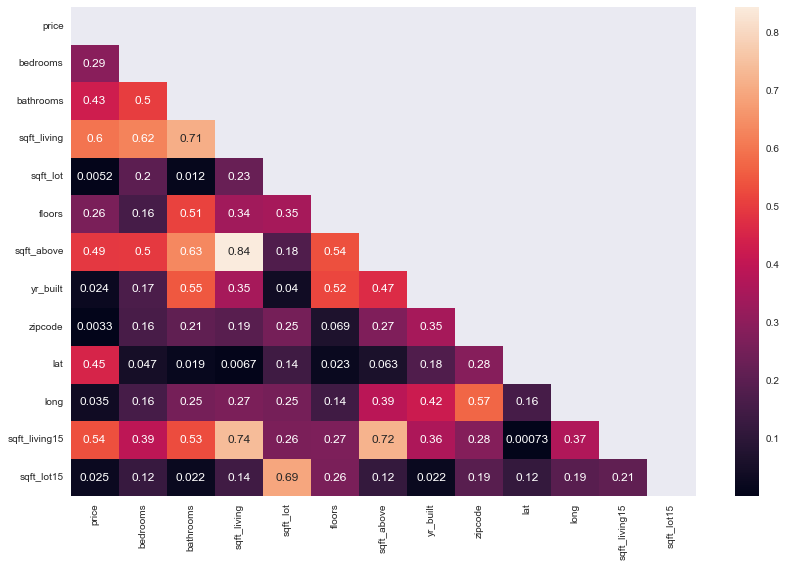

In [39]:
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    f.savefig('images/Corelation Heatmap',bbox_inches="tight")

### Model 1

In [40]:
cols = ['sqft_living']
y = y_train
x = X_train.filter(cols, axis=1)
y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [41]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.35205094281398364
    test score: 0.37900938149625407


In [79]:
y_sqft_liv = df['price']
X_sqft_liv = df[['sqft_living']]

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:36:56   Log-Likelihood:            -2.4446e+05
No. Observations:               18212   AIC:                         4.889e+05
Df Residuals:                   18210   BIC:                         4.889e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.454e+05   3405.658     42.699      0.000    1.39e+05    1.52e+05
sqft_living   168.2449      1.667    100.941      0.000     164.978     171.512
==============================================================================
Omnibus:                      823.794   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              938.325
Skew:                           0.549   Prob(JB):                    1.76e-204
Kurtosis:                       3.171   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2

In [80]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [81]:
X_train_scaled, X_test_scaled, train_preds, test_preds=scale_score(x, y, x2, y2)

training score: 0.5146097689254998
    test score: 0.5242363120859779


In [82]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.515
Mean Absolute Error: 106446.524
Mean Squared Error: 20290796941.321
Root Mean Squared Error: 142445.768

Testing Metrics:
R2: 0.524
Mean Absolute Error: 105338.990
Mean Squared Error: 19613364607.964
Root Mean Squared Error: 140047.723


### Model 2b

In [46]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'zipcode']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [47]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3993413028686136
    test score: 0.4109408603232637


In [48]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.399
Mean Absolute Error: 127074.905
Mean Squared Error: 25109371541.226
Root Mean Squared Error: 158459.369

Testing Metrics:
R2: 0.411
Mean Absolute Error: 125592.315
Mean Squared Error: 24283971172.305
Root Mean Squared Error: 155833.152


### Model 3

In [70]:
cols = ['bedrooms', 'sqft_living', 'sqft_living15']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [71]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3806771591076463
    test score: 0.4005020902108569


In [51]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.798
Mean Absolute Error: 67040.807
Mean Squared Error: 8452413133.869
Root Mean Squared Error: 91937.006

Testing Metrics:
R2: 0.809
Mean Absolute Error: 65267.174
Mean Squared Error: 7861974770.888
Root Mean Squared Error: 88667.778


### Model 3b

In [52]:
cols = ['sqft_living', 'sqft_living15'] + encoded_bedrooms_bins + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [53]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.799227552045403
    test score: 0.8114168190412745


In [54]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.799
Mean Absolute Error: 66764.908
Mean Squared Error: 8392902683.353
Root Mean Squared Error: 91612.787

Testing Metrics:
R2: 0.811
Mean Absolute Error: 64862.175
Mean Squared Error: 7774344240.710
Root Mean Squared Error: 88172.242


### Model 4

In [55]:
cols = ['bedrooms', 'sqft_living'] + encoded_condition + encoded_zipcode 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [56]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7882553234618938
    test score: 0.8019139401688504


In [57]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.788
Mean Absolute Error: 68359.691
Mean Squared Error: 8851575412.899
Root Mean Squared Error: 94082.811

Testing Metrics:
R2: 0.802
Mean Absolute Error: 65715.248
Mean Squared Error: 8166100553.528
Root Mean Squared Error: 90366.479


### Model 4b

In [58]:
cols = ['sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [59]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7899254758710148
    test score: 0.8043563330303309


In [60]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.790
Mean Absolute Error: 68112.963
Mean Squared Error: 8781757931.572
Root Mean Squared Error: 93711.034

Testing Metrics:
R2: 0.804
Mean Absolute Error: 65248.085
Mean Squared Error: 8065412874.067
Root Mean Squared Error: 89807.644


### Model 5

In [61]:
cols = ['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'view'] + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [62]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8040314404358433
    test score: 0.8109625646254899


In [63]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.804
Mean Absolute Error: 66343.096
Mean Squared Error: 8192085448.850
Root Mean Squared Error: 90510.140

Testing Metrics:
R2: 0.811
Mean Absolute Error: 64588.874
Mean Squared Error: 7793070885.277
Root Mean Squared Error: 88278.372


### Model 5b

In [66]:
cols = ['bathrooms', 'sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [67]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8073561781701597
    test score: 0.8144964137689303


In [68]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.807
Mean Absolute Error: 65794.564
Mean Squared Error: 8053101237.938
Root Mean Squared Error: 89739.073

Testing Metrics:
R2: 0.814
Mean Absolute Error: 63897.108
Mean Squared Error: 7647387905.511
Root Mean Squared Error: 87449.345
